In [30]:
# Scientific imports

%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astroquery.mast import Observations
from astroquery.mast import Catalogs

# General imports

import csv, math, os, os.path, sys, random, gc
import pandas as pd
import seaborn as sb
from sklearn import metrics
from IPython.display import display
from collections import Counter

plt.rcParams["figure.figsize"] = (20,9)
sb.set()

###################################################

import types

def GetElementAt(self, row, col):
    if col<1 or row <1:
        print("Error: Must have Row, Col must be 1 or greater!")
        return 0
    else:
        return(self.at[row,self.columns[col-1]])

###################################################

planet_list ="tsop301_planet_data.txt"
star_list   ="tsop301_star_data.txt"
eb_list     ="tsop301_eb_data.txt"
beb_list    ="tsop301_backeb_data.txt"

def LoadList(itemtype="all"):
    
    foundflag=False
    
    # itemtype = (S)tar, (P)lanet, (E)clipsing (B)inary, or (B)ack (E)clipsing (B)inary
    if itemtype.lower() in ["s", "star", "all"]:
        foundflag = True
        global starlist
        starlist = LoadListGeneral(star_list)
        print("Loading star list: {}".format(star_list))
    if itemtype.lower() in ["p", "planet", "all"]:
        foundflag = True
        global planetlist
        planetlist = LoadListGeneral(planet_list)
        print ("loading planet list: {}".format(planet_list))
    if itemtype.lower() in ["eb", "eclipsing binary", "eclipsingbinary", "all"]:
        foundflag = True
        global eblist
        eblist = LoadListGeneral(eb_list)
        print ("loading eb list: {}".format(eb_list))
    if itemtype.lower() in ["beb", "back eclipsing binary", "backeclipsingbinary", "all"]:
        foundflag = True
        global beblist
        beblist = LoadListGeneral(beb_list)
        print ("loading beb list: {}".format(beb_list))
        
    if foundflag:
        global alllists
        alllists = {"s": starlist, "p": planetlist, "eb": eblist, "beb": beblist}
        return alllists
    else:
        # If an invalid selection has been entered
        print("You must enter either:\n"
               "* \"S\" (or \"Star\")\n"
               "* \"P\" (or \"Planet\")\n"
               "* \"EB\" (or \"Eclipsing Binary\")\n"
               "* \"BEB\" (or \"Back Eclipsing Binary\")")
        
def IsThisAStar(n):
    return n in alllists["s"]
    
def IsThisAPlanet(n):
    return n in alllists["p"]

def IsThisAEB(n):
    return n in alllists["eb"]

def IsThisABEB(n):
    return n in alllists["beb"]

# Function to tell you what an item is
def WhatIsMyLC(n):
    lbl = []
    lbl.append("Star") if IsThisAStar(n) else lbl
    lbl.append("Planet") if IsThisAPlanet(n) else lbl
    lbl.append("EB") if IsThisAEB(n) else lbl
    lbl.append("BRB") if IsThisABEB(n) else lbl
    
    return "UNKNOWN" if lbl==[] else lbl

def LoadListGeneral(f):
    lst=[]
    try:
        # Assuming everything CAN go well, do this
        with open('./SIM_DATA/unpacked/{}'.format(f)) as df:
            csvdf = csv.reader(df)
            for lineholder in csvdf:
                line = lineholder[0]                # 'lineholder' is a list, 1 element long, containing only a single string
                if line[0]!="#":                    # Ignore commented lines (lines w/ FIRST STRING ELEMENT is a # character)
                    lst.append(line.split()[0])     # Add line to list
                # endif
            # endfor
        # endwith
    except FileNotFoundError:
        print("FNF")
        return
    # end try
    return lst

def LoadListFull(f,n=6):
    # numHeaders = 6 but this is defined later on; using default value here for sake of making it work
    lst =[]
    hlst=[]
    try:
        # Assuming everything CAN go well, do this
        with open('./SIM_DATA/unpacked/{}'.format(f)) as df:
            csvdf = csv.reader(df)
            for ln, lineholder in enumerate(csvdf):
                line = lineholder[0]                # 'lineholder' is a list, 1 element long, containing only a single string
                
                #print(lineholder[0][2])             # this should be a number
                #print("{} : {}".format(type(lineholder[0][2]), lineholder[0][2].isdigit()))
                
                if lineholder[0][2:3].isdigit() and int(lineholder[0][2:4]) <= n:
                    
                    # STUFF
                    #print(line)
                    hcontent = line.split(' - ')[1]
                    hlst.append(hcontent)
                
                if line[0]!="#":                    # Ignore commented lines (lines w/ FIRST STRING ELEMENT is a # character)
                    
                    if len(lst) == 0:
                        # Stuff to happen while len(lst) == 0
                        lst.append(hlst)
                    
                    content = line.split()[:6]
                    #print(content)
                    lst.append(content)    # Add line to list
                    
                # endif
            # endfor
        # endwith
    except FileNotFoundError:
        print("FNF")
        return
    # end try
    return lst

def MakingAList(prnt=False):
    fl = []
    fitsroot = "SIM_DATA/"
    fits_directories = [x[0] for x in os.walk('./SIM_DATA/.', topdown=True)]

    for fitsroot, fits_dirs, fits_files in os.walk(fitsroot):
        for fits_file in fits_files:
            fullpath = os.path.join(fitsroot, fits_file)
            if (os.path.splitext(fullpath.lower())[1]).endswith('.fits'):
                fl.append(fullpath)
    if prnt==True:
        print("Number of FITS files: {}".format(len(fl)))
    #print(len(fl))
    return fl

# So every item in the inputArr list is a TIC.
# Therefore finding the index in TICList of each item will give us the FITS file to load
# Can also check by checking name of file

def NPlanetFluxes(inputArr):

    outputArr = [None]*len(inputArr)

    for i in range(len(inputArr)):

        # Initialise stuff for easier searching
        TIC = inputArr[i]
        index = TICList.index(TIC)
        fitsFile = fitsList[index]

        # CHECK IF CORRECT FITS FILE FOR GIVEN TIC
        if str(TICList[index]) not in fitsList[index]:
            print("ERR @ {}".format(index))
            break
        else:
#            # Populate flux list
#            with fits.open(fitsFile, mode="readonly", mammap=False) as hdulist:
#                pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
#                outputArr[i] = pdcsap_fluxes
            
            # Populate flux list
            hdulist = fits.open(fitsFile, mode="readonly", mammap=False)
            
            pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
            outputArr[i] = pdcsap_fluxes
            
            hdulist.close()

    # Final Validation
    print("Length of inputArr = {}".format(len(inputArr)))
    print("Length of outputArr = {}".format(len(outputArr)))
    print("Length of flux list = {}".format(len(outputArr[0])))
    
    # Return
    return(outputArr)

# So every item in the inputArr list is a TIC.
# Therefore finding the index in TICList of each item will give us the FITS file to load
# Can also check by checking name of file

def NPlanetFluxesSingle(TIC):
    # Initialise stuff for easier searching
    index = TICList.index(TIC)
    fitsFile = fitsList[index]

    # CHECK IF CORRECT FITS FILE FOR GIVEN TIC
    if str(TICList[index]) not in fitsList[index]:
        print("ERR @ {}".format(index))
        return 0
    else:  
        # OPEN THE FILE
        hdulist = fits.open(fitsFile, mode="readonly", mammap=False)
        
        # Get data
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
        #outputArr[num] = pdcsap_fluxes
        
        # CLOSE THE FILE
        hdulist.close()
        
        # Garbage Collect
        gc.collect()
    
    # Return
    return(pdcsap_fluxes)

def DrawLC(N=-1):
    rndFile = random.randint(0,len(fitsList))
    #print("FILE IS {}".format(rndFile))
    #fileNum = fitsList[rndFile]
    fitsFile = fitsList[rndFile] if N==-1 else fitsList[N]

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        obj = hdulist[0].header['OBJECT']
        sector = hdulist[0].header['SECTOR']

        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds = hdulist[1].data['TIME']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    #return (tess_bjds[1:-1], pdcsap_fluxes[1:-1], str(rndFile), str(obj), str(sector))
    return (tess_bjds, pdcsap_fluxes, str(rndFile), str(obj), str(sector))


# Python3 implementation to find elements
# that appeared only once
# Function to find the elements that
# appeared only once in the array
def occurredOnce(in_arr, out_arr, count=1):
    
    n = len(in_arr)
    #counting frequency of every element using Counter
    mp=Counter(in_arr)
    # Traverse the map and print all
    # the elements with occurrence 1
    for it in mp:
        if mp[it] == count:
            out_arr.append(int(it))
            #print(it, end = " ")
            
            

# [f(x) for x in sequence if condition]
# [f(x) if condition else g(x) for x in sequence]

def MakeNewPlanetLists(inArr):

    newIsPlanetList=[0]*len(inArr)
    print("Length of newIsPlanetList is {}".format(len(newIsPlanetList)))

    for i in inArr:
        ind = TICList.index(i)
        newIsPlanetList[ind] = 1
    
    return (newIsPlanetList)

def MakeNewPlanetListsNew(inArr):

    newIsPlanetList=[None]*len(inArr)

    for n,i in enumerate(inArr):
        # Now that we are looping thru each item in the list, I can do a lookup
        # check each item against PLANETLIST and see if the item exists within
        
        #print("n,i = {}, {}".format(n,i))
        
        query = 1 if i in planetList else 0
        
        #print("Query = {}".format(query))
        
        newIsPlanetList[n] = query
    
    return (newIsPlanetList)

def DrawLC(rndFile=-1):
    
    # rndFile is random, unless specified
    rndFile = random.randint(0,len(fitsarr)) if rndFile==-1 else rndFile
    
    # Get LC data from the requisite fits file
    fitsFile = fitsarr[rndFile]

    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        star_teff = hdulist[0].header['TEFF']
        star_logg = hdulist[0].header['LOGG']
        star_tmag = hdulist[0].header['TESSMAG']
        obj       = hdulist[0].header['OBJECT']
        sector    = hdulist[0].header['SECTOR']


        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds     = hdulist[1].data['TIME']
        sap_fluxes    = hdulist[1].data['SAP_FLUX']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    # X- and Y- labels
    #ylab = "PDCSAP Flux (e-/s)"
    ylab = "SAP Flux (e-/s)"
    xlab = "Time (TBJD)"

                        # pdcsap_fluxes[1:-1]
    return (tess_bjds[1:-1], sap_fluxes[1:-1], str(rndFile), str(obj), str(sector), ylab, xlab)

#################################
def Initialise():
    fitsarr=np.load("fitslist.npy")
    master_list = LoadList()
    return(fitsList, master_list)
#################################

In [33]:
# RUN ALL INITIALISERS

    
(fitsarr, master_list) = Initialise()
starList, planetList, ebList, bebList = master_list['s'], master_list['p'], master_list['eb'], master_list['beb']
starList   = [int(x) for x in starList]
planetList = [int(x) for x in planetList]
ebList     = [int(x) for x in ebList]
bebList    = [int(x) for x in bebList]

Loading star list: tsop301_star_data.txt
loading planet list: tsop301_planet_data.txt
loading eb list: tsop301_eb_data.txt
loading beb list: tsop301_backeb_data.txt


In [3]:
# 1 - TIC ID [int] - Target identifier 
# 2 - Planet Number [int] - Multiple planets per target are present
# 3 - Orbital Period [days]
# 4 - Epoch [BTJD] - Barycentric Julian Data with zeropoint convenient for TESS
#                    JD - 2457000.0 = BTJD
# 5 - Rp/Rstar - Ratio planet radius to stellar host radius
# 6 - Rp [Rearth] - Planet radius

numHeaders = 6
planetListFull = LoadListFull(planet_list)

In [4]:
planetListFull[:6]

[['TIC ID [int]',
  'Planet Number [int]',
  'Orbital Period [days]',
  'Epoch [BTJD]',
  'Rp/Rstar',
  'Rp [Rearth]'],
 ['6353299', '1', '27.4142299', '1022.430671', '0.03971', '1.799'],
 ['6353299', '2', '7.2762520', '1001.429162', '0.03885', '1.760'],
 ['6400274', '1', '146.3632622', '1114.341527', '0.03146', '5.738'],
 ['6471862', '1', '80.4104278', '1033.250807', '0.03272', '5.622'],
 ['6471862', '2', '7.7901323', '1004.126029', '0.03606', '6.195']]

In [5]:
df = pd.DataFrame(planetListFull)
df.columns = df.iloc[0]
df = df[1:]
#df['NewName'] = df['TIC ID [int]']+'-'+df['Planet Number [int]']
df.insert(loc=2, column='NewName', value=df['TIC ID [int]']+'-'+df['Planet Number [int]'])

# GET ELEMENT
df.at[1,df.columns[3]]

df.GetElementAt = types.MethodType(GetElementAt, df)

In [6]:
df[:6]

,TIC ID [int],Planet Number [int],NewName,Orbital Period [days],Epoch [BTJD],Rp/Rstar,Rp [Rearth]
1,6353299,1,6353299-1,27.4142299,1022.430671,0.03971,1.799
2,6353299,2,6353299-2,7.2762520,1001.429162,0.03885,1.760
3,6400274,1,6400274-1,146.3632622,1114.341527,0.03146,5.738
4,6471862,1,6471862-1,80.4104278,1033.250807,0.03272,5.622
5,6471862,2,6471862-2,7.7901323,1004.126029,0.03606,6.195
6,6471862,3,6471862-3,145.7113215,1068.305639,0.01398,2.402


In [7]:
#df.GetElementAt(ROW,COLUMN)
df.GetElementAt(3,4)

'146.3632622'

In [8]:
#TICList = [0]*len(fitsList)
#
## Make a list of EVERY TIC IN ORDER
#for i in range(len(fitsList)):
#    with fits.open(fitsList[i], mode="readonly") as hdulist:
#        obj = hdulist[0].header['OBJECT']
#        TICList[i] = int(obj.split('TIC ')[1])
#
#np.save("TICList",TICList)

In [9]:
TICList=list(np.load("TICList.npy"))

In [10]:
testf=int(df.GetElementAt(1,1))
c=0
for ctr, val in enumerate(TICList):
    if val == testf:
        print("C:{}, V:{}".format(ctr,val))
        c=ctr

C:5616, V:6353299


In [11]:
# Make a list of EVERY TIC IN ORDER
for i in range(len(fitsList)):
    with fits.open(fitsList[i], mode="readonly") as hdulist:
        obj = hdulist[0].header['OBJECT']
        TICList[i] = int(obj.split('TIC ')[1])
        
isPlanetList = [None]*len(TICList)
isEbList     = [None]*len(TICList)
isBebList    = [None]*len(TICList)
isStarList   = [None]*len(TICList)

In [12]:
# Time to do many loops

for i in range(len(TICList)):
    # The isPlanetList defaults to zero; check if TICList[i] is in plist
    #OBJ = str(TICList[i])
    OBJ = int(TICList[i])
    
    if OBJ in planetList:
        #print(OBJ)
        isPlanetList[i] = i
        # isPlanetList[i] = [OBJ, planetList.index(OBJ)]
        
    if OBJ in ebList:
        isEbList[i] = i
        # isEbList[i] = [OBJ, ebList.index(OBJ)]
        
    if OBJ in bebList:
        isBebList[i] = i
        # isBebList[i] = [OBJ, bebList.index(OBJ)]
        
    if OBJ in starList:
        isStarList[i] = i
        # isStarList[i] = [OBJ, starList.index(OBJ)]

In [13]:
isPlanetListShort = [i for i in isPlanetList if i != None]
isEbListShort     = [i for i in isEbList     if i != None]
isBebListShort    = [i for i in isBebList    if i != None]
isStarListShort   = [i for i in isStarList   if i != None]

In [14]:
#len(isPlanetListShort)
#isPlanetListShort[:10]

In [15]:
one_planet_lcs = []
two_planet_lcs = []
three_planet_lcs = []
four_planet_lcs = []
five_planet_lcs = []
six_planet_lcs = []
occurredOnce(planetList, one_planet_lcs)
occurredOnce(planetList, two_planet_lcs   ,2)
occurredOnce(planetList, three_planet_lcs ,3)
occurredOnce(planetList, four_planet_lcs  ,4)
occurredOnce(planetList, five_planet_lcs  ,5)
occurredOnce(planetList, six_planet_lcs   ,6)

maxPlanets=6
planet_lcs = []
for i in range(maxPlanets):
    planet_lcs.append([])

for i in range(maxPlanets):
    #print("occurredOnce(planetList, planet_lcs[{}],{})".format(i,i+1))
    occurredOnce(planetList, planet_lcs[i],i+1)

In [16]:
for i in range(len(planet_lcs)):
    print("Number of LCs with {} exoplanet(s): {}".format(i+1,len(planet_lcs[i])))

Number of LCs with 1 exoplanet(s): 1115
Number of LCs with 2 exoplanet(s): 1082
Number of LCs with 3 exoplanet(s): 534
Number of LCs with 4 exoplanet(s): 260
Number of LCs with 5 exoplanet(s): 155
Number of LCs with 6 exoplanet(s): 0


387294245
15880


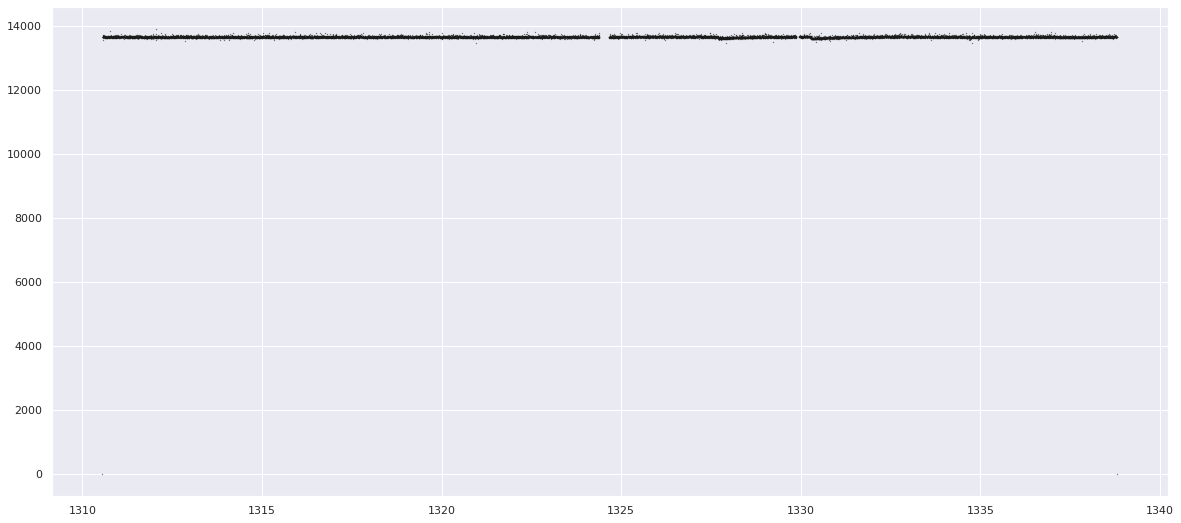

In [17]:
tstTIC = random.choice(one_planet_lcs)
fileNum = TICList.index(tstTIC)
print(tstTIC)
print(fileNum)

x,y,f,o,s = DrawLC(fileNum)
plt.plot(x,y,'k.',markersize=0.5)

In [18]:
one_planet_lcs[0]

6400274

In [19]:
TICList.index(one_planet_lcs[0])

9088

In [20]:
TICList[9088]

6400274

Text(0, 0.5, 'SAP Flux (e-/s)')

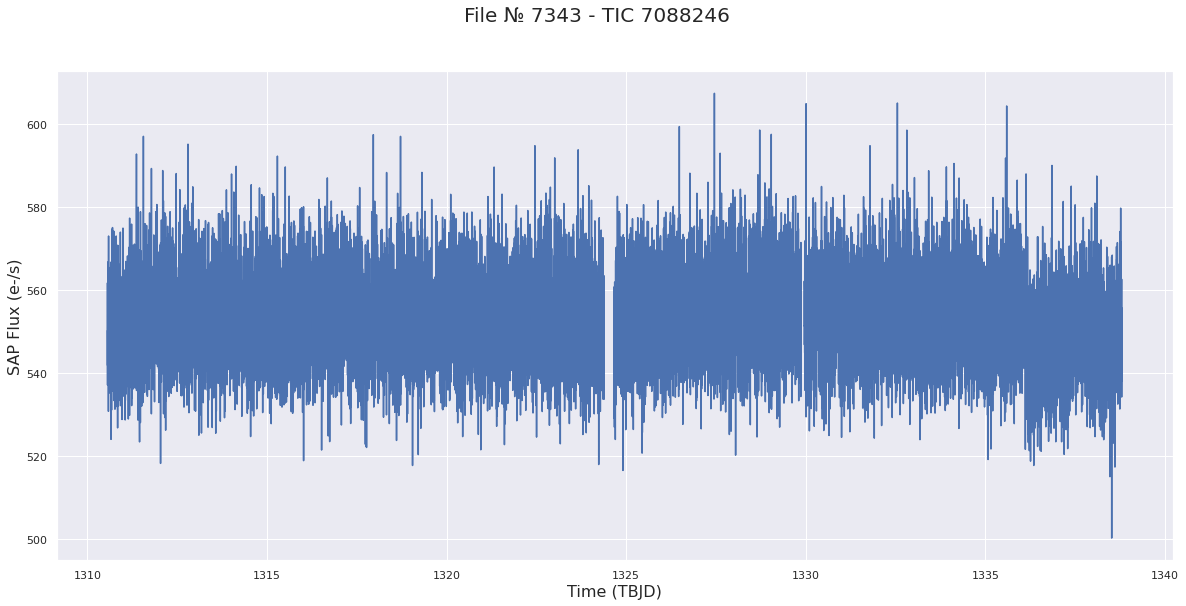

In [38]:
x,y,f,o,s,ylab,xlab = DrawLC(TICList.index(one_planet_lcs[2]))

fig, ax = plt.subplots()
ax.plot(x,y)
fig.suptitle("File № {} - {}".format(f, o), fontsize=20) # + str(obj) + " - Sector " + str(sector))
ax.set_xlabel(xlab, fontsize=16)
ax.set_ylabel(ylab, fontsize=16)

### I want to make a list of TICs with ONLY 0 planets OR 1 planet
### So I'll need to start by making a list of just TICs of just stars, and one-planet LCs

In [24]:
print(starList[0:10])
print(one_planet_lcs[0:10])

zero_or_one_exoplanets = starList + one_planet_lcs

print(len(zero_or_one_exoplanets))
print(len(list(set(zero_or_one_exoplanets))))

# Since the lengths between the list and the set are different, there must be some LCs that are stars and also 1 exoplanet
# Therefore we can reduce the list to the set, because if it is a star and also a single exoplanet, it counts as an exoplanet

zero_or_one_exoplanets = list(set(zero_or_one_exoplanets))
zero_or_one_exoplanets.sort()

[6286534, 6289424, 6353299, 6354567, 6355904, 6401116, 6406550, 6407080, 6472196, 6477929]
[6400274, 6949210, 7088246, 61090239, 61135882, 61326006, 61458992, 61811090, 61897601, 62119727]
9739
9154


In [25]:
zero_or_one_exoplanets[:25]

[1159914,
 1160976,
 1247610,
 1479793,
 1637295,
 1640268,
 1640949,
 1714271,
 1776724,
 1851563,
 2208752,
 2372579,
 2372796,
 2377428,
 2669197,
 2674349,
 6286534,
 6289424,
 6353299,
 6354567,
 6355904,
 6400274,
 6401116,
 6406550,
 6407080]

In [22]:
# Good, so now we have a list of 0 or 1 exoplanets. Time to make a new "isplanetlist"
#newIsPlanetList = [None]*len(zero_or_one_exoplanets)

newIsPlanetList = MakeNewPlanetListsNew(zero_or_one_exoplanets)

In [23]:
len(newIsPlanetList)

9154

In [24]:
newIsPlanetList[-10:]

[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [25]:
#np.save("one_or_none_isplanetlist",newIsPlanetList)

In [26]:
#newIsPlanetList = np.load("one_or_none_isplanetlist.npy")

In [27]:
none_or_one_fluxlist = [None]*len(zero_or_one_exoplanets)

In [28]:
# Smaller lists

sep = 3000

none_or_one_fluxlist_a = [None]*sep
none_or_one_fluxlist_b = [None]*sep
none_or_one_fluxlist_c = [None]*(len(zero_or_one_exoplanets)-(2*sep))

In [ ]:
part_a = zero_or_one_exoplanets[0:sep]

for n,i in enumerate(part_a):
    none_or_one_fluxlist_a[n] = NPlanetFluxesSingle(i)
    if (n % (len(part_a)//100) == 0):
        print("{}, ".format((n//(sep//100))+1),end='')

In [ ]:
np.save("Z_or_O_a",none_or_one_fluxlist_a)
gc.collect()

In [42]:
part_b = zero_or_one_exoplanets[sep:2*sep]

for n,i in enumerate(part_b):
    none_or_one_fluxlist_b[n] = NPlanetFluxesSingle(i)
    if (n % (len(part_b)//100) == 0):
        print("{}, ".format((n//(sep//100))+1),end='')

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 

In [43]:
np.save("Z_or_O_b",none_or_one_fluxlist_b)
gc.collect()

17

In [29]:
part_c = zero_or_one_exoplanets[2*sep:]

for n,i in enumerate(part_c):
    none_or_one_fluxlist_c[n] = NPlanetFluxesSingle(i)
    if (n % (len(part_c)//100) == 0):
        print("{}, ".format((n//(sep//100))+1),end='')

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 

In [30]:
np.save("Z_or_O_c",none_or_one_fluxlist_c)
gc.collect()

17

In [31]:
A=np.load("Z_or_O_a.npy")
B=np.load("Z_or_O_b.npy")
C=np.load("Z_or_O_c.npy")

none_or_one_fluxlist = list(A)+list(B)+list(C)

print(len(none_or_one_fluxlist))

np.save("None_Or_One_Exoplanet",none_or_one_fluxlist)

9154


In [32]:
len(zero_or_one_exoplanets)

9154

In [ ]:
#np.save("one_planet_fluxlist",NPlanetFluxes(one_planet_lcs))

#np.save("two_planet_fluxlist",NPlanetFluxes(two_planet_lcs))

#np.save("three_planet_fluxlist",NPlanetFluxes(three_planet_lcs))

#np.save("four_planet_fluxlist",NPlanetFluxes(four_planet_lcs))

#np.save("five_planet_fluxlist",NPlanetFluxes(five_planet_lcs))

## THIS IS POINTLESS BECAUSE WE NEED THE FULL FLUX LIST, BUT WE NEED TO MODIFY THE "ISPLANETARR" TO PROPERLY ACCOMMODATE MULTIPLANETS

In [ ]:
#np.save("isplanetlist_one",  MakeNewPlanetLists(one_planet_lcs))
#np.save("isplanetlist_two",  MakeNewPlanetLists(two_planet_lcs))
#np.save("isplanetlist_three",MakeNewPlanetLists(three_planet_lcs))
#np.save("isplanetlist_four", MakeNewPlanetLists(four_planet_lcs))
#np.save("isplanetlist_five", MakeNewPlanetLists(five_planet_lcs))